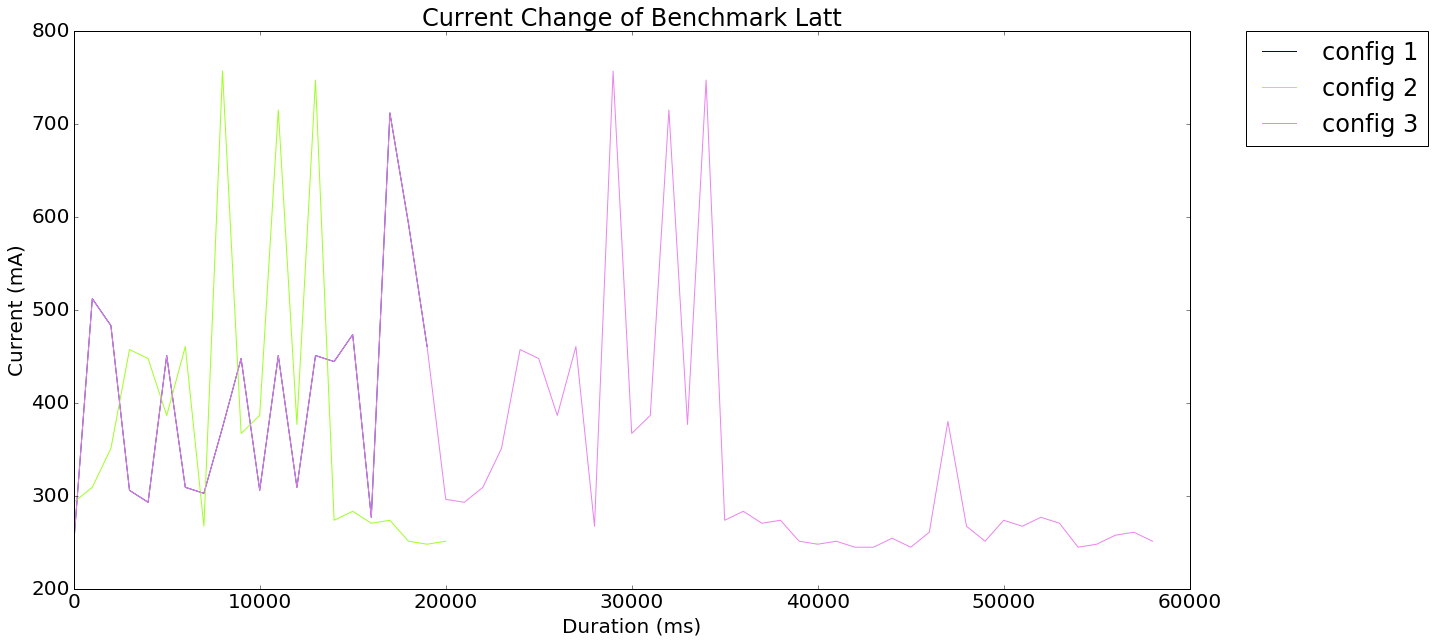

In [2]:
from cycler import cycler

import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


def extract_currents(path_current, start, finish):
    with open(path_current, 'r') as f:
        currents = []
        prog = re.compile('\]\s*([\d\.]+)')
        started = False
        finished = False
        
        for line in f:
            if started and finish in line:
                finished = True
                break
                
            if start in line:
                started = True
            
            if started:
                m = re.search(prog, line)
                if m:
                    currents.append(m.group(1))

        if not started or not finished:
            raise ValueError('Invalid start_time or finish_time')
        else:
            return currents

def extract_all_currents(path_time_slots, path_current):
    currents_of_benches = []
    try:
        with open(path_time_slots, 'r') as f:
            for raw in f:
                line = raw.strip()
                if line:
                    if re.match(r'#', line):
                        continue

                    comps = [c.strip() for c in line.split(',')]
                    if len(comps) != 3:
                        raise ValueError('Must be 3 components in time slot line: ' + line)

                    try:
                        currents = extract_currents(path_current, comps[0], comps[1])
                    except ValueError as err:
                        print('Invalid time slot: ' + line, err)
                        raise
                    
                    item = {}
                    item['currents'] = currents
                    item['label'] = comps[2]
                    currents_of_benches.append(item)

        return currents_of_benches
    except IOError:
        print('File ' + path_time_slots + ' not exist.')
        

def plot(currents_of_benches, sample_rate, bench_name):
    plt.figure(figsize = (20,10))
    plt.rcParams.update({'font.size': 20})
    
    # Have a look at the colormaps here and decide which one you'd like:
    # http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
    colormap = plt.cm.gist_ncar
    plt.gca().set_prop_cycle(cycler('color', [colormap(i) for i in np.linspace(0, 0.9, len(currents_of_benches))]))
    
    max_length = max([len(item['currents']) for item in currents_of_benches])
    x = np.arange(0, max_length * sample_rate, sample_rate)
    
    for item in currents_of_benches:
        currents = item['currents']
        plt.plot(x[:len(currents)], currents, label=item['label'])

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Current Change of Benchmark ' + bench_name)
    plt.ylabel('Current (mA)')
    plt.xlabel('Duration (ms)')
    
    plt.show()


PATH_TIME_SLOTS = './time_slots.txt'
PATH_CURRENT = './current.log'
SAMPLE_RATE = 1000    # In Milliseconds
BENCH_NAME = 'Latt'

# do plot
plot(extract_all_currents(PATH_TIME_SLOTS, PATH_CURRENT), SAMPLE_RATE, BENCH_NAME)